In [134]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.signal import periodogram
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from itertools import chain

warnings.filterwarnings('ignore')
%matplotlib inline

In [135]:
from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [136]:
df = pd.read_csv('train.csv', sep =',')
df

,id,epoch,sat_id,x,y,z,x_sim,y_sim,z_sim,type
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-8843.131454,13138.221690,-20741.615306,train
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-10555.500066,1649.289367,-24473.089556,train
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,-10571.858472,-10145.939908,-24271.169776,train
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,-9149.620794,-20618.200201,-20765.019094,train
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,-6729.358857,-28902.271436,-14992.399986,train
...,...,...,...,...,...,...,...,...,...,...
649907,1234089,2014-01-31T22:00:22.602,599,NaN,NaN,NaN,-20717.958996,-16245.240500,5250.939232,test
649908,1234090,2014-01-31T22:25:13.240,599,NaN,NaN,NaN,-22673.444496,-11192.339393,5243.608790,test
649909,1234091,2014-01-31T22:50:03.878,599,NaN,NaN,NaN,-23461.830699,-5570.167175,4966.813869,test
649910,1234092,2014-01-31T23:14:54.515,599,NaN,NaN,NaN,-22858.679929,373.249102,4396.055679,test


In [137]:
df['error']  = np.array(np.linalg.norm(df[['x', 'y', 'z']].values - df[['x_sim', 'y_sim', 'z_sim']].values, axis=1))

temp2 = df.copy()
temp2.sort_values('epoch', axis=0, inplace=True)
temp2['epoch'] = pd.to_datetime(temp2.epoch,format='%Y-%m-%d %H:%M:%S') 
temp2.index = temp2.epoch
temp2 = temp2.drop(columns = 'epoch')

#err = temp2[temp2.type=='train']['error']
#err = err.iloc[-int(len(err)/2):]


In [138]:


sat_id_max =df.sat_id.max()
train_err = temp2[temp2.type == 'train']
test_err = temp2[temp2.type == 'test']
res = []
for sat in tqdm(range(sat_id_max + 1)):
    train = train_err[train_err.sat_id == sat]
    
    train = train.iloc[-int(train.count()[0]/2):]

    test = test_err[test_err.sat_id == sat]
    model = ExponentialSmoothing(np.asarray(train.error) ,seasonal_periods=24 , seasonal='additive').fit()
    forecast = pd.DataFrame(model.forecast(len(test)),index = test.index)
    res.append(forecast.values)
    
res = list(chain.from_iterable(res))

In [139]:
result = pd.DataFrame()
df1 = df[df.type == 'test']
result['id'] = np.array(test_err.id.sort_values().astype(int))
result['error']  = res
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162708 entries, 0 to 162707
Data columns (total 2 columns):
id       162708 non-null int32
error    162708 non-null object
dtypes: int32(1), object(1)
memory usage: 1.9+ MB


In [140]:
with open('my_sub.csv', mode='w', encoding='utf-8') as f_csv:
    result.to_csv(f_csv, index=False)

Решение заканчивается здесь, далее идет черновик

In [32]:
temp = df.copy()
temp = temp[(temp.sat_id == 0)]
temp = temp.drop(columns = ['epoch','y','z','y_sim','z_sim', 'sat_id'])
temp.index = temp.id
temp = temp.drop(columns = 'id')
temp

,x,x_sim,type
id,,,
0,-8855.823863,-8843.131454,train
1,-10567.672384,-10555.500066,train
2,-10578.684043,-10571.858472,train
3,-9148.251857,-9149.620794,train
4,-6719.092336,-6729.358857,train
...,...,...,...
953,NaN,15425.677762,test
954,NaN,13419.744899,test
955,NaN,10662.661170,test


In [33]:

model = LinearRegression()
train_temp = temp[temp.type == 'train'].drop(columns ='type')
test_temp = temp[temp.type == 'test'].drop(columns ='type')

model.fit(pd.DataFrame(train_temp.x_sim) ,pd.DataFrame(train_temp.x))

forecast = model.predict(test_temp.drop(columns ='x')).reshape(1,-1)
forecast = list(chain.from_iterable(forecast))
forecast = pd.Series(forecast)

#test_temp.x = forecast
test_temp = pd.DataFrame({'x':forecast.values, 'x_sim': test_temp.x_sim}, index = test_temp.index)
test_temp
asd = pd.concat([train_temp,test_temp])
print(temp)
temp[['x','x_sim']] = asd
temp

                x         x_sim   type
id                                    
0    -8855.823863  -8843.131454  train
1   -10567.672384 -10555.500066  train
2   -10578.684043 -10571.858472  train
3    -9148.251857  -9149.620794  train
4    -6719.092336  -6729.358857  train
..            ...           ...    ...
953           NaN  15425.677762   test
954           NaN  13419.744899   test
955           NaN  10662.661170   test
956           NaN   7182.757625   test
957           NaN   3099.591832   test

[958 rows x 3 columns]


,x,x_sim,type
id,,,
0,-8855.823863,-8843.131454,train
1,-10567.672384,-10555.500066,train
2,-10578.684043,-10571.858472,train
3,-9148.251857,-9149.620794,train
4,-6719.092336,-6729.358857,train
...,...,...,...
953,15199.018089,15425.677762,test
954,13236.962910,13419.744899,test
955,10540.187504,10662.661170,test


In [36]:
temp2 = df.copy()
temp2.sort_values('epoch', axis=0, inplace=True)
temp2 = temp2[(temp2.sat_id == 0)]
temp2 = temp2.drop(columns = ['id','y','z','y_sim','z_sim', 'sat_id'])
temp2.index = temp2.epoch
temp2 = temp2.drop(columns = 'epoch')
temp2

,x,x_sim,type
epoch,,,
2014-01-01T00:00:00.000,-8855.823863,-8843.131454,train
2014-01-01T00:46:43.000,-10567.672384,-10555.500066,train
2014-01-01T01:33:26.001,-10578.684043,-10571.858472,train
2014-01-01T02:20:09.001,-9148.251857,-9149.620794,train
2014-01-01T03:06:52.002,-6719.092336,-6729.358857,train
...,...,...,...
2014-01-31T20:27:33.474,NaN,15425.677762,test
2014-01-31T21:14:16.474,NaN,13419.744899,test
2014-01-31T22:00:59.475,NaN,10662.661170,test


len_train -  75
len_test -  71
len_train -  146
len_test -  71
len_train -  217
len_test -  71
len_train -  288
len_test -  71


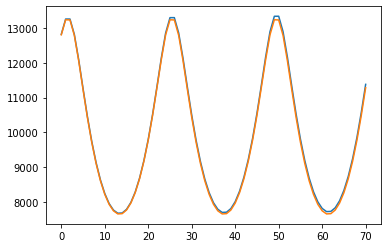

In [42]:
from sklearn.model_selection import TimeSeriesSplit 
errors = []
    

#temp1 = temp[temp.type == 'train']
#temp1 = temp1.drop(columns='type')
#temp2 = temp[temp.type == 'train']
#temp2 = temp2.drop(columns='type')
tscv = TimeSeriesSplit(n_splits=4)
for train_idx, test_idx in tscv.split(err):
    #print(train_idx)
    #print(test_idx)
    print('len_train - ', len(train_idx))
    print('len_test - ', len(test_idx))
    model = ExponentialSmoothing(np.asarray(err.iloc[train_idx]) ,seasonal_periods=24 , seasonal='additive').fit()
    forecast = pd.Series(model.forecast(len(test_idx)))
    #model = Holt(np.asarray(temp2.x.iloc[train_idx])).fit(smoothing_level = 0.5,smoothing_slope = 0.5)
    #model = SimpleExpSmoothing(np.asarray(temp2.x.iloc[train_idx])).fit(smoothing_level = 0.5,optimized=False)
    #model = ExponentialSmoothing(np.asarray(temp2.x.iloc[train_idx]) ,seasonal_periods=24 , seasonal='additive').fit()
   
    #forecast = pd.Series(model.forecast(len(test_idx)))
    #model = LinearRegression()
    #train_temp = temp1.iloc[train_idx]
    #test_temp = temp1.iloc[test_idx]

    #model.fit(pd.DataFrame(train_temp.x_sim) ,pd.DataFrame(train_temp.x))
    #forecast = (model.predict(pd.DataFrame(test_temp.x_sim)))
    #forecast = list(chain.from_iterable(forecast))
    #forecast = pd.Series(forecast)
    actual = err.iloc[test_idx]
    error = smape(actual.values, forecast.values)
    errors.append(error)
plt.plot(actual.values)
plt.plot(forecast.values)

In [31]:
errors

[9.818542647398397, 50.775524662941415, 50.91546194443688, 51.14724626311217]

In [84]:
temp2 = df.copy()
temp2.sort_values('epoch', axis=0, inplace=True)
temp2.index = temp2.epoch
temp2 = temp2.drop(columns = 'epoch')
temp2

,id,sat_id,x,y,z,x_sim,y_sim,z_sim,type
epoch,,,,,,,,,
2014-01-01T00:00:00.000,0,0,-8855.823863,13117.780146,-20728.353233,-8843.131454,13138.221690,-20741.615306,train
2014-01-01T00:00:00.000,213266,118,10171.370412,-139.857014,-7230.080495,10296.585520,-410.519487,-6967.486116,train
2014-01-01T00:00:00.000,212766,117,-14676.389914,-21654.086115,6227.056578,-16945.138598,-19784.607650,7339.687381,train
2014-01-01T00:00:00.000,772510,381,-17461.309881,23615.553044,-18460.888702,-17499.774329,23586.498252,-18437.302581,train
2014-01-01T00:00:00.000,166651,83,-6489.158823,-22861.728367,-33642.953108,-6480.600040,-22890.997437,-33671.495789,train
...,...,...,...,...,...,...,...,...,...
2014-01-31T23:59:41.071,912714,456,NaN,NaN,NaN,-8730.847251,-24418.385994,-4107.201598,test
2014-01-31T23:59:49.232,13119,5,NaN,NaN,NaN,9346.080572,-10654.238300,349.853331,test
2014-01-31T23:59:56.109,340182,184,NaN,NaN,NaN,10972.381365,2131.614755,-7008.177163,test


,id,sat_id,x,y,z,x_sim,y_sim,z_sim,type
epoch,,,,,,,,,
2014-01-01T00:00:00.000,0.0,0.0,-8855.823863,13117.780146,-20728.353233,-8843.131454,13138.221690,-20741.615306,train
2014-01-01T00:00:00.000,213266.0,118.0,10171.370412,-139.857014,-7230.080495,10296.585520,-410.519487,-6967.486116,train
2014-01-01T00:00:00.000,212766.0,117.0,-14676.389914,-21654.086115,6227.056578,-16945.138598,-19784.607650,7339.687381,train
2014-01-01T00:00:00.000,772510.0,381.0,-17461.309881,23615.553044,-18460.888702,-17499.774329,23586.498252,-18437.302581,train
2014-01-01T00:00:00.000,166651.0,83.0,-6489.158823,-22861.728367,-33642.953108,-6480.600040,-22890.997437,-33671.495789,train
...,...,...,...,...,...,...,...,...,...
2014-01-31T23:59:41.071,912714.0,456.0,4258.351162,-23533.574081,-2469.769922,-8730.847251,-24418.385994,-4107.201598,test
2014-01-31T23:59:49.232,13119.0,5.0,7226.897537,-12349.446200,163.590019,9346.080572,-10654.238300,349.853331,test
2014-01-31T23:59:56.109,340182.0,184.0,10408.601052,3561.064919,-7055.862285,10972.381365,2131.614755,-7008.177163,test


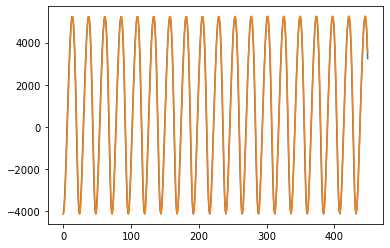

In [85]:
#df1 = df.copy()
df1 = temp2.copy()
coords = ['x','y','z']
model = LinearRegression()
sat_id_max = df.sat_id.max()
train_df = df1[df1.type=='train']
test_df = df1[df1.type == 'test']
for sat in tqdm(range(sat_id_max + 1)):
    train = train_df[train_df.sat_id == sat]
    test = test_df[test_df.sat_id == sat]
    for coord in coords:
        model = ExponentialSmoothing(np.asarray(train[coord]) ,seasonal_periods=24 , seasonal='additive').fit()
        forecast = pd.Series(model.forecast(len(test)))
        #model.fit(pd.DataFrame(train[coord]),pd.DataFrame(train[coord + '_sim']))
        #forecast = model.predict(pd.DataFrame(test[coord + '_sim']))
        #forecast = list(chain.from_iterable(forecast))
        #forecast = pd.Series(forecast)
        test_temp = pd.DataFrame({coord:forecast.values, coord + '_sim': test[coord + '_sim']}, index = test.index)
        test[[coord,coord + '_sim']] = test_temp
    df1.update(test)

actual = test[coord + '_sim']
plt.plot(forecast.values)
plt.plot(actual.values)
df1

In [86]:
result = pd.DataFrame()
df1 = df1[df1.type == 'test']
result['id'] = np.array(df1.id.astype(int))
result['error']  = np.array(np.linalg.norm(df1[['x', 'y', 'z']].values - df1[['x_sim', 'y_sim', 'z_sim']].values, axis=1))
print(result)

             id         error
0        887375  49298.456134
1        810351  39483.224178
2       1021929  19660.059220
3        523004  29104.211566
4        738240  26923.826591
...         ...           ...
162703   912714  13121.865341
162704    13119   2720.176572
162705   340182   1537.351581
162706   405533   8208.570461
162707   950054   3863.097757

[162708 rows x 2 columns]


In [133]:
with open('my_sub.csv', mode='w', encoding='utf-8') as f_csv:
    result.to_csv(f_csv, index=False)

In [59]:
df2 = pd.read_csv('sub.csv', sep =',')
df2
#print(pd.DataFrame({'x':pd.Series(forecast.values),'x_sim':pd.Series(actual.values)},indices = actual.indices))

,id,error
0,718,987
1,719,987
2,720,987
3,721,987
4,722,987
...,...,...
162703,1234089,987
162704,1234090,987
162705,1234091,987
162706,1234092,987


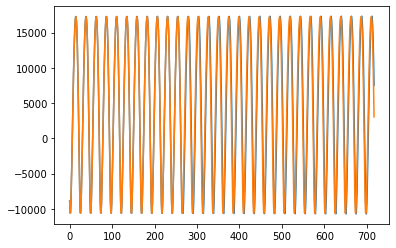

In [10]:
plt.plot(temp1)

In [14]:
df.sort_values('epoch', axis=0, inplace=True)
df.epoch = pd.to_datetime(df.epoch, format='%Y-%m-%d %H:%M:%S')
df.index = df.epoch
df.drop('epoch', axis = 1, inplace = True)
df.head(2)

,id,sat_id,x,y,z,x_sim,y_sim,z_sim,type
epoch,,,,,,,,,
2014-01-01,0,0,-8855.823863,13117.780146,-20728.353233,-8843.131454,13138.221690,-20741.615306,train
2014-01-01,213266,118,10171.370412,-139.857014,-7230.080495,10296.585520,-410.519487,-6967.486116,train


In [10]:
tmp = df.copy()
rcParams['figure.figsize'] = 20, 5
tmp['year'] = tmp.index.year
tmp['month'] = tmp.index.month
tmp['hour'] = tmp.index.hour
tmp['dow'] = tmp.index.dayofweek
tmp_pivot = pd.pivot_table(tmp, values = "x", columns = "year", index = "month")
tmp_pivot.head(3)

year,2014
month,
1,-866.65363


In [15]:
df_x = df
df_x = df_x.drop(columns = ['y', 'z', 'y_sim', 'z_sim'])
df_x = df_x[df_x.type == 'train']
df_x_1 = df_x[df_x.sat_id == 0]
df_x_1

,id,sat_id,x,x_sim,type
epoch,,,,,
2014-01-01 00:00:00.000,0,0,-8855.823863,-8843.131454,train
2014-01-01 00:46:43.000,1,0,-10567.672384,-10555.500066,train
2014-01-01 01:33:26.001,2,0,-10578.684043,-10571.858472,train
2014-01-01 02:20:09.001,3,0,-9148.251857,-9149.620794,train
2014-01-01 03:06:52.002,4,0,-6719.092336,-6729.358857,train
...,...,...,...,...,...
2014-01-24 02:22:16.354,713,0,16800.702412,15393.800187,train
2014-01-24 03:08:59.355,714,0,15583.002314,13377.855305,train
2014-01-24 03:55:42.355,715,0,13634.892367,10613.983951,train


In [16]:
df_x_1.drop(columns=['type','sat_id'])

,id,x,x_sim
epoch,,,
2014-01-01 00:00:00.000,0,-8855.823863,-8843.131454
2014-01-01 00:46:43.000,1,-10567.672384,-10555.500066
2014-01-01 01:33:26.001,2,-10578.684043,-10571.858472
2014-01-01 02:20:09.001,3,-9148.251857,-9149.620794
2014-01-01 03:06:52.002,4,-6719.092336,-6729.358857
...,...,...,...
2014-01-24 02:22:16.354,713,16800.702412,15393.800187
2014-01-24 03:08:59.355,714,15583.002314,13377.855305
2014-01-24 03:55:42.355,715,13634.892367,10613.983951


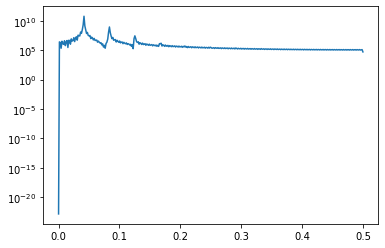

In [44]:
tmp = df_x_1.drop(columns='id')
p, ind  = periodogram(tmp.x, axis = 0)
plt.semilogy(p, ind)
plt.show()

In [45]:
spec = pd.DataFrame(ind,index=p)
top = spec.nlargest(3,columns=0)

In [46]:
time = 1/top.index
time

Float64Index([23.933333333333334, 24.75862068965517, 23.161290322580644], dtype='float64')

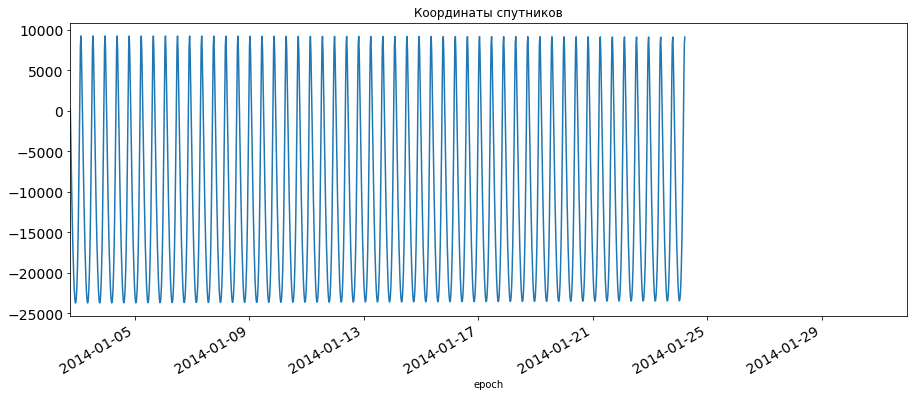

In [55]:
df[(df.sat_id == 10)].iloc[100:].y.plot(figsize=(15,6),title= 'Координаты спутников', fontsize=14)
#df[df.sat_id == 10].y_sim.plot(figsize=(15,6),title= 'Координаты спутников', fontsize=14)

In [46]:
df[df.sat_id == 10].x.describe()

count     1324.000000
mean     -9772.600479
std      14981.996949
min     -28217.874705
25%     -23647.741646
50%     -12625.805292
75%       5083.738405
max      15148.503410
Name: x, dtype: float64

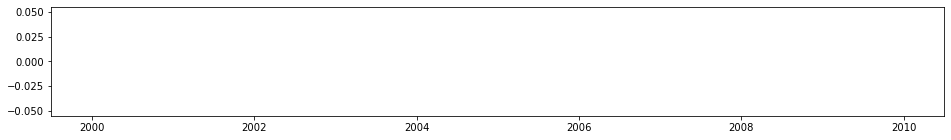

In [62]:
plt.figure(figsize=(16,2))
mean = df[df.sat_id == 10].x.rolling(window=2400*30*6).mean()
plt.plot(mean)
plt.show()

In [72]:
fit = SimpleExpSmoothing(np.asarray(df[(df.sat_id == 0) & (df.type == 'train')].x)).fit(smoothing_level=1,optimized=False)
fit.forecast(10)

array([7516.62215488, 7516.62215488, 7516.62215488, 7516.62215488,
       7516.62215488, 7516.62215488, 7516.62215488, 7516.62215488,
       7516.62215488, 7516.62215488])

In [69]:
df[(df.sat_id == 0) & (df.type == 'train')].x

epoch
2014-01-01 00:00:00.000    -8855.823863
2014-01-01 00:46:43.000   -10567.672384
2014-01-01 01:33:26.001   -10578.684043
2014-01-01 02:20:09.001    -9148.251857
2014-01-01 03:06:52.002    -6719.092336
                               ...     
2014-01-24 02:22:16.354    16800.702412
2014-01-24 03:08:59.355    15583.002314
2014-01-24 03:55:42.355    13634.892367
2014-01-24 04:42:25.356    10938.273245
2014-01-24 05:29:08.356     7516.622155
Name: x, Length: 718, dtype: float64

In [76]:
df[df.sat_id == 0].nsmallest(4,'x')

,id,sat_id,x,y,z,x_sim,y_sim,z_sim,type
epoch,,,,,,,,,
2014-01-23 15:28:14.347,699,0,-10712.120286,-9156.565906,-24393.963351,-9262.290274,-20666.094926,-20730.392305,train
2014-01-22 20:47:02.335,675,0,-10707.884485,-9192.425198,-24387.809376,-9258.373437,-20664.142861,-20731.017165,train
2014-01-22 02:05:50.324,651,0,-10703.523444,-9228.275024,-24382.060210,-9254.341423,-20661.990927,-20732.143597,train
2014-01-21 07:24:38.312,627,0,-10698.997252,-9264.009238,-24376.749190,-9250.220144,-20659.706860,-20733.746972,train


In [ ]:
seasonality_mins = 18 * 60 + 41
seasonality_id = 24